# Homework 6

## FINM 35700 - Spring 2025

### UChicago Financial Mathematics

### Due Date: 2025-05-06

* Matheus Raka Pradnyatama
* matheusraka@uchicago.edu

This homework relies on multiple files (from previous weeks):

- the bond symbology file `bond_symbology`, 
- the "on-the-run" treasuries data file `govt_on_the_run`,
- the bond market data file `bond_market_prices_eod`,
- the SOFR OIS Swap symbology file `sofr_swap_symbology`,
- the SOFR OIS Swap market data file `sofr_swaps_market_data_eod`.

-----------------------------------------------------------
# Parametric Credit Models: 
# Nelson-Siegel credit model for smooth hazard rate curves

### This homework  implements some of the concepts introduced in Lecture 6, "Parametric Hazard Rate Models"

### Follow the "Smooth parametric yield and hazard rate curves: the Nelson-Siegel model" in the "Smooth Credit Models" notebook
### You can also take a look at Dr. Mark Hendricks Fixed Income notebooks describing the Nelson-Siegel model calibration on US Treasuries.
-----------------------------------------------------------

In [178]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import QuantLib as ql
import datetime as dt
from scipy.optimize import fsolve
from scipy.optimize import root_scalar
from scipy.optimize import minimize

# The code is made with the help of OpenAI's ChatGPT.

# import tools from previous homeworks
from credit_market_tools import *

# Use static calculation/valuation date of 2024-12-13, matching data available in the market prices EOD file
calc_date = ql.Date(13, 12, 2024)
ql.Settings.instance().evaluationDate = calc_date

# Calculation/valuation date as pd datetime
as_of_date = pd.to_datetime('2024-12-13')

In [179]:
# nelson_siegel curve shape: Nelson-Siegel
def nelson_siegel(params, maturity):
    ''' params = (theta1, theta2, theta3, lambda)'''    
    
    if(maturity > 0):
        slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])
    else:            
        slope_1 = 1

    curvature_1 = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature_1
    
    return total_value

# nelson_siegel_extended curve shape: Nelson-Siegel-Svensson
def nelson_siegel_extended(params, maturity):

    if(maturity > 0):
        slope_1 = (1 - np.exp(-maturity/params[3]))/(maturity/params[3])
    else:            
        slope_1 = 1

    curvature_1 = slope_1 - np.exp(-maturity/params[3])

    total_value = params[0] + params[1] * slope_1 + params[2] * curvature_1    
    
    if(params[5] != 0):
        if(maturity > 0):
            slope_2 = (1 - np.exp(-maturity/params[5]))/(maturity/params[5])
        else:
            slope_2 = 1

        curvature_2 = slope_2 - np.exp(-maturity/params[5])

        total_value = total_value + params[4] * curvature_2
        
    
    return total_value


-----------------------------------------------------------
# Problem 1: Market Data preparation

## a. Prepare the VZ bond market data as of 2024-12-13
Load the symbology + market data dataframes and create a combined dataframe for all Verizon (ticker = 'VZ') fixed rate (cpn_type == 'FIXED') bonds with an outstanding amount greater than $100 MM (amt_out > 100).

Sort the dataframe by bond maturity and display the head of the dataframe.

Plot the VZ yields (Y-axis) by TTM (X-axis).

,date,isin,ticker,cpn_type,amt_out,maturity,midPrice,midYield,term,TTM
452,2024-12-13,US92343VGG32,VZ,FIXED,838.579,2026-03-20,96.2510,4.5405,4.993840,1.264887
428,2024-12-13,US92343VDD38,VZ,FIXED,984.778,2026-08-15,97.1630,4.4105,10.036961,1.670089
433,2024-12-13,US92343VDY74,VZ,FIXED,2938.298,2027-03-16,98.9935,4.5980,9.998631,2.253251
441,2024-12-13,US92343VFF67,VZ,FIXED,597.057,2027-03-22,96.5850,4.6020,7.003422,2.269678
453,2024-12-13,US92343VGH15,VZ,FIXED,2164.531,2028-03-22,92.2255,4.6940,7.000684,3.271732


,date,class,ticker,isin,figi,bidPrice,askPrice,accrued,bidYield,askYield,...,acc_first,maturity,mty_typ,rank,amt_out,country,currency,status,term,TTM
452,2024-12-13,Corp,VZ,US92343VGG32,BBG00ZLKTF09,96.175,96.327,0.3460,4.605,4.476,...,2021-03-22,2026-03-20,CALLABLE,Sr Unsecured,838.579,US,USD,ACTV,4.993840,1.264887
428,2024-12-13,Corp,VZ,US92343VDD38,BBG00DGYP877,97.011,97.315,0.8820,4.508,4.313,...,2016-08-01,2026-08-15,AT MATURITY,Sr Unsecured,984.778,US,USD,ACTV,10.036961,1.670089
433,2024-12-13,Corp,VZ,US92343VDY74,BBG00G6QW2B8,98.920,99.067,1.0315,4.633,4.563,...,2017-03-16,2027-03-16,AT MATURITY,Sr Unsecured,2938.298,US,USD,ACTV,9.998631,2.253251
441,2024-12-13,Corp,VZ,US92343VFF67,BBG00SK3XVL1,96.470,96.700,0.7000,4.657,4.547,...,2020-03-20,2027-03-22,CALLABLE,Sr Unsecured,597.057,US,USD,ACTV,7.003422,2.269678
453,2024-12-13,Corp,VZ,US92343VGH15,BBG00ZLKTF27,92.132,92.319,0.4905,4.727,4.661,...,2021-03-22,2028-03-22,CALLABLE,Sr Unsecured,2164.531,US,USD,ACTV,7.000684,3.271732


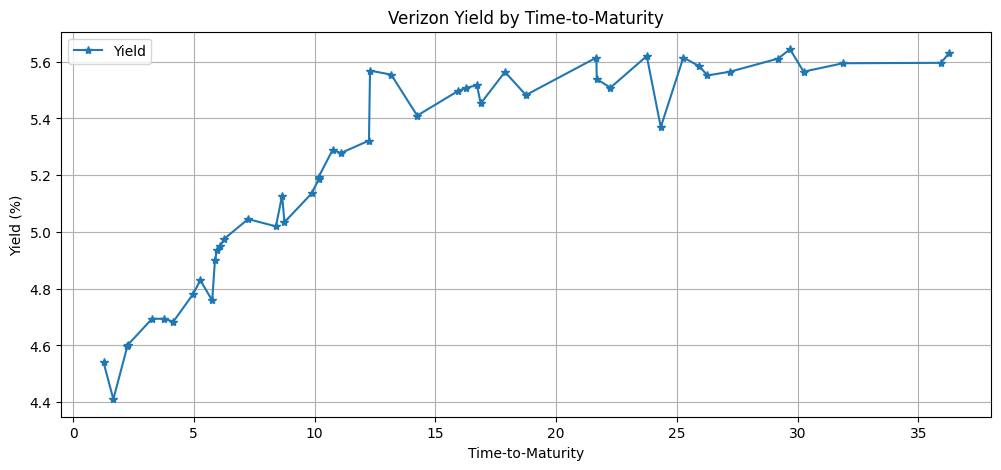

In [180]:
# Bond Symbology Dataframe = Containing both corporate and US Government Bonds
filepath_rawdata = f'./data/bond_symbology.xlsx'
bond_symbology = pd.read_excel(filepath_rawdata)
days_in_year = 365.25
date_today = pd.to_datetime('2024-12-13')
bond_symbology['term'] = ((bond_symbology['maturity']) - bond_symbology['start_date']).dt.days /days_in_year
bond_symbology['TTM'] = ((bond_symbology['maturity'] - date_today)).dt.days /days_in_year
bond_symbology.loc[bond_symbology['TTM'] <= 0, 'TTM'] = 0 # If TTM is less than or equal to 0, then it's 0
# display(bond_symbology.head(3))

# Dataframe of market prices
filepath_rawdata = f'./data/bond_market_prices_eod.xlsx'
data_market = pd.read_excel(filepath_rawdata)
data_market['midPrice'] = (data_market['bidPrice'] + data_market['askPrice'])/2
data_market['midYield'] = (data_market['bidYield'] + data_market['askYield'])/2
# display(data_market.head(3))

# Symbology + Market
df_merged_symbo_market = pd.merge(data_market, bond_symbology, on=['isin', 'class', 'figi', 'ticker'], how='inner')

# Verizon Dataframe with cpn_type == FIXED and amt_out > 100, sorted by maturity
df_vz = df_merged_symbo_market[(df_merged_symbo_market['ticker'] == 'VZ') & 
                               (df_merged_symbo_market['cpn_type'] == 'FIXED') & 
                               (df_merged_symbo_market['amt_out'] > 100)
                               ].sort_values(by = 'maturity')

display(df_vz[['date', 'isin', 'ticker', 'cpn_type', 'amt_out', 'maturity', 'midPrice', 'midYield', 'term', 'TTM']].head())
display(df_vz.head())

plt.figure(figsize=(12, 5))
plt.plot(df_vz['TTM'], df_vz['midYield'], '*-', label='Yield') # X-axis values first, then Y-axis values
plt.title(f'Verizon Yield by Time-to-Maturity')
plt.xlabel('Time-to-Maturity')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid()
plt.show()

## b. Compute bond yields and risk metrics
For each bond, use the bond market mid-price as an input to compute the:

1. bond yields,
2. bond DV01s and
3. bond durations.

You can use section "9. Analytical Duration" in the QuantLib Basics notebook as a template.


In [ ]:
# Bond Setup
compounding = ql.Compounded
coupon_freq = ql.Semiannual
day_count = ql.Thirty360(ql.Thirty360.USA)      # For US Corporate bonds use ql.Thirty360(ql.Thirty360.USA)

fixed_rate_bond_objects = []
bond_market_prices = []    
bond_yields = []
bond_DV01s = []    
bond_durations = []    
df_to_iterate = df_vz

for index, row in df_to_iterate.iterrows():
    bond = create_bond_from_symbology(row)
    fixed_rate_bond_objects.append(bond)

    # Use the midPrice from the dataset
    bond_clean_price = row['midPrice']
    
    # Compute implied bond yield directly from bond_clean_price (Quantlib Basics Section 7)
    bond_yield = bond.bondYield(bond_clean_price, bond.dayCounter(), compounding, coupon_freq)
    bond_yield_rate = ql.InterestRate(bond_yield, day_count, compounding, coupon_freq)

    # Obtain the dirty price from the bond's object
    bond_dirty_price = bond.dirtyPrice(bond_yield, bond.dayCounter(), compounding, coupon_freq)

    bond_duration = ql.BondFunctions.duration(bond, bond_yield_rate)
    bond_convexity = ql.BondFunctions.convexity(bond, bond_yield_rate)
    bond_DV01 = bond_dirty_price * bond_duration / 100

    # Add to the list
    bond_market_prices.append(bond_clean_price)
    bond_yields.append(bond_yield*100) # Show in percent
    bond_DV01s.append(bond_DV01)
    bond_durations.append(bond_duration)   

# Add to dataframe
df_vz['bond_yield'] = bond_yields
df_vz['bond_duration'] = bond_durations
df_vz['bond_DV01'] = bond_DV01s

# Relevant field
df_filtered = df_vz[['ticker', 'security', 'midPrice', 'midYield', 'TTM', 'bond_yield', 'bond_duration', 'bond_DV01']]
display(df_filtered.head())

,ticker,security,midPrice,midYield,TTM,bond_yield,bond_duration,bond_DV01
452,VZ,VZ 1.45 03/20/26,96.2510,4.5405,1.264887,4.540637,1.222316,1.180725
428,VZ,VZ 2 5/8 08/15/26,97.1630,4.4105,1.670089,4.410096,1.589535,1.558465
433,VZ,VZ 4 1/8 03/16/27,98.9935,4.5980,2.253251,4.598220,2.102004,2.102524
441,VZ,VZ 3 03/22/27,96.5850,4.6020,2.269678,4.601817,2.142891,2.084712
453,VZ,VZ 2.1 03/22/28,92.2255,4.6940,3.271732,4.693826,3.081289,2.856832


## c. Calibrate the US Treasury curve
### Calibrate the "on-the-run" US Treasury curveas of 2024-12-13:

... to be used in the hazard rate model calibration.

,date,isin,ticker,midPrice,midYield,term,TTM
0,2024-12-13,US91282CMB45,T,99.37890,4.2225,2.995209,3.003422
1,2024-12-13,US91282CLY56,T,100.00390,4.2470,1.993155,1.963039
2,2024-12-13,US91282CMA61,T,99.44140,4.2510,4.993840,4.963723
3,2024-12-13,US91282CLZ22,T,98.80470,4.3255,6.992471,6.962355
4,2024-12-13,US91282CLW90,T,98.82030,4.3980,9.998631,9.921971
5,2024-12-13,US912810UE63,T,98.34375,4.6020,29.998631,29.921971
6,2024-12-13,US912810UF39,T,99.26565,4.6820,19.953457,19.923340


,Date,YearFrac,DiscountFactor,ZeroRate
0,2024-12-13,0.000,1.000,4.127
1,2026-11-30,2.000,0.921,4.212
2,2027-12-15,3.000,0.882,4.279
3,2029-11-30,5.000,0.812,4.263
4,2031-11-30,7.000,0.742,4.357
5,2034-11-15,9.917,0.648,4.475
6,2044-11-15,19.917,0.390,4.839
7,2054-11-15,29.917,0.256,4.654


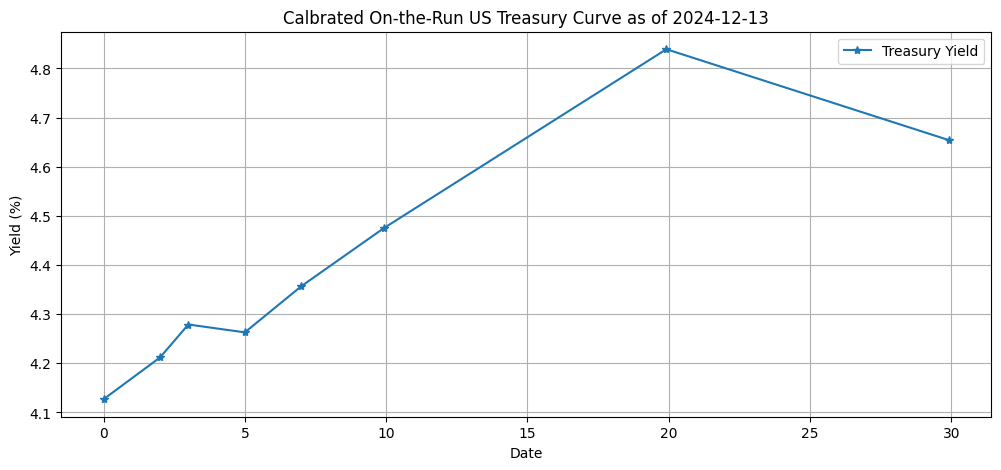

In [182]:
filepath_rawdata = f'./data/govt_on_the_run.xlsx'
df_govt = pd.read_excel(filepath_rawdata)
# r'[BC] Govt$' matches string that ends with B Govt or C Govt
# ~ negates the filter, showing rows that DO NOT match the filter (those that don't have BC)
df_ontherun = df_govt[~df_govt['ticker'].str.contains(r'[BC] Govt$', regex=True)]
# display(df_ontherun.head(3))

# Bond Symbology Dataframe = Containing both corporate and US Government Bonds
filepath_rawdata = f'./data/bond_symbology.xlsx'
bond_symbology = pd.read_excel(filepath_rawdata)
days_in_year = 365.25
date_today = pd.to_datetime('2024-12-13')
bond_symbology['term'] = ((bond_symbology['maturity']) - bond_symbology['start_date']).dt.days /days_in_year
bond_symbology['TTM'] = ((bond_symbology['maturity'] - date_today)).dt.days /days_in_year
bond_symbology.loc[bond_symbology['TTM'] <= 0, 'TTM'] = 0 # If TTM is less than or equal to 0, then it's 0
# display(bond_symbology.head(3))

# Dataframe of market prices
filepath_rawdata = f'./data/bond_market_prices_eod.xlsx'
data_market = pd.read_excel(filepath_rawdata)
data_market['midPrice'] = (data_market['bidPrice'] + data_market['askPrice'])/2
data_market['midYield'] = (data_market['bidYield'] + data_market['askYield'])/2
# display(data_market.head(3))

# Symbology + Market
df_merged_symbo_market = pd.merge(data_market, bond_symbology, on=['isin', 'class', 'figi', 'ticker'], how='inner')

# Symbology + Market + On the Run
govt_combined_otr = pd.merge(df_merged_symbo_market, df_ontherun['isin'], on=['isin'], how='inner')

display(govt_combined_otr[['date', 'isin', 'ticker', 'midPrice', 'midYield', 'term', 'TTM']])

# tsy_yield_curve calibration
govt_combined_otr = govt_combined_otr
tsy_yield_curve = calibrate_yield_curve_from_frame(calc_date, govt_combined_otr, 'midPrice')
tsy_yield_curve_handle = ql.YieldTermStructureHandle(tsy_yield_curve)

tsy_yield_curve_mid_details = get_yield_curve_details_df(tsy_yield_curve, curve_dates=None)
display(tsy_yield_curve_mid_details)

# Input for Scatter Plot
plt.figure(figsize=(12, 5))
plt.plot(tsy_yield_curve_mid_details['YearFrac'], tsy_yield_curve_mid_details['ZeroRate'], '*-', label='Treasury Yield')
plt.title(f'Calbrated On-the-Run US Treasury Curve as of {calc_date.to_date()}')
plt.xlabel('Date')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid()
plt.show()

-----------------------------------------------------------
# Problem 2: Add functions needed to calibrate the Nelson-Siegel (4 parameters) credit model

## a. For a given set of Nelson-Siegel curve shape parameters, write a function to create the corresponding parametric credit curve.
The result should be a DefaultProbabilityTermStructureHandle object, to be used downstream for pricing.

To do: compute nelson_siegel_credit_curve_handle

nelson_siegel_credit_curve_handle = ql.DefaultProbabilityTermStructureHandle(...)

In [183]:
def create_nelson_siegel_curve(calc_date, nelson_siegel_params):
    ''' nelson_siegel_params = (theta1, theta2, theta3, lambda)'''            
    nelson_siegel_surv_prob_dates = [calc_date + ql.Period(T , ql.Years) for T in range(31)]
    nelson_siegel_average_hazard_rates = [nelson_siegel(nelson_siegel_params, T) for T in range(31)]
    nelson_siegel_surv_prob_levels = [np.exp(-T * nelson_siegel_average_hazard_rates[T]) for T in range(31)]
    
    # cap and floor survival probs, to ensure they are in (0, 1]
    nelson_siegel_surv_prob_levels = [max(min(x,1),1e-8) for x in nelson_siegel_surv_prob_levels]

    # nelson_siegel_surv_prob_curve
    nelson_siegel_credit_curve = ql.SurvivalProbabilityCurve(nelson_siegel_surv_prob_dates, nelson_siegel_surv_prob_levels, ql.Actual360(), ql.TARGET())
    nelson_siegel_credit_curve.enableExtrapolation()
    nelson_siegel_credit_curve_handle = ql.DefaultProbabilityTermStructureHandle(nelson_siegel_credit_curve)
    
    return(nelson_siegel_credit_curve_handle)

## b. Write a function to price all bonds in the Nelson-Siegel credit model

Use 40% recovery rate.

Using DefaultProbabilityTermStructureHandle as an input to compute all model prices and yields.

In [184]:
def calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4):
    
    # nelson_siegel_surv_prob_curve_handle
    nelson_siegel_surv_prob_curve_handle = create_nelson_siegel_curve(calc_date, nelson_siegel_params)
    
    # nelson_siegel_risky_bond_engine
    nelson_siegel_risky_bond_engine = ql.RiskyBondEngine(nelson_siegel_surv_prob_curve_handle, bond_recovery_rate, tsy_yield_curve_handle)
    
    bond_model_prices = []
    bond_model_yields = []
    
    for fixed_rate_bond in fixed_rate_bond_objects:
        fixed_rate_bond.setPricingEngine(nelson_siegel_risky_bond_engine)
        
        bond_price = fixed_rate_bond.cleanPrice()                
        bond_yield = fixed_rate_bond.bondYield(bond_price, ql.Thirty360(ql.Thirty360.USA), ql.Compounded, ql.Semiannual) * 100
        
        bond_model_prices.append(bond_price)
        bond_model_yields.append(bond_yield)
    
    return(bond_model_prices, bond_model_yields)


## c. Write a function to computes the weighted SSE / "Sum of Squared Errors" metric
Write a function to compute the weighted SSE / "Sum of Squared Errors" in price space, defined as sum of squared differences between model and market prices for all Verizon fixed-rate bonds.

Use 1/DV01 as SSE weights, as discussed in Lecture 6. You can ignore the liquidity adjuster for the purpose of this exercise.

In [185]:
def nelson_siegel_sse(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      market_prices, 
                      calib_weights,
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4):
    
    # bond_model_prices
    bond_model_prices, bond_model_yields = calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      tsy_yield_curve_handle, 
                      bond_recovery_rate)
    # sse    
    sse = 0
    
    for i in range(len(market_prices)):
        model_error = market_prices[i] - bond_model_prices[i]                
        sse += model_error * model_error * calib_weights[i]                        
    
    return(sse)    

## d. Test the functionalty on the initial set of model parameters: 
## initial_nelson_siegel_params = [0.03, -0.01, 0.02, 5.0]

Compute the corresponding initial model prices and yields, as well as initial SSE.

Add following columns to the VZ dataframe and display the head of the results:

| duration | calib_weight | initModelPrice | initModelYield |
|----------|----------|----------|----------|


In [186]:
# Calibration Weights
calib_weights = [1 / d for d in bond_DV01s]
sum_calib_weights = sum(calib_weights)
calib_weights = [x / sum_calib_weights for x in calib_weights]
df_vz['calib_weight'] = calib_weights

# NS Params
initial_nelson_siegel_params = [0.03, -0.01, 0.02, 5.0]
nelson_siegel_params = initial_nelson_siegel_params 
initModelPrice, initModelYield =  calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4)

df_vz['initModelPrice'] = initModelPrice
df_vz['initModelYield'] = initModelYield

# Relevant field
df_filtered = df_vz[['security', 'midPrice', 'midYield', 'TTM', 'calib_weight', 'initModelPrice', 'initModelYield']]
display(df_filtered.head())

,security,midPrice,midYield,TTM,calib_weight,initModelPrice,initModelYield
452,VZ 1.45 03/20/26,96.2510,4.5405,1.264887,0.100202,95.146125,5.483991
428,VZ 2 5/8 08/15/26,97.1630,4.4105,1.670089,0.075915,95.309715,5.614381
433,VZ 4 1/8 03/16/27,98.9935,4.5980,2.253251,0.056271,96.660427,5.724514
441,VZ 3 03/22/27,96.5850,4.6020,2.269678,0.056752,94.369654,5.679874
453,VZ 2.1 03/22/28,92.2255,4.6940,3.271732,0.041414,89.133337,5.798073


In [187]:
# Calculate SSE
initial_SSE = nelson_siegel_sse(
    initial_nelson_siegel_params, # Use initial params
    calc_date,
    fixed_rate_bond_objects,
    bond_market_prices, 
    calib_weights, 
    tsy_yield_curve_handle, 
    bond_recovery_rate = 0.4)

print(f'initial_SSE: {initial_SSE:.4f}')

initial_SSE: 31.2035


-----------------------------------------------------------
# Problem 3: Calibrate the Nelson-Siegel model
## a. Find the Nelson-Siegel model parameters providing the smooth credit curve which best fits the market.

Use the US "on-the-run" Treasury yield curve for risk-free discounting.

Minimize the SSE (model vs market pricing error) function to obtain the optimal/calibrated Nelson-Siegel parameter vector. 

Create the calibrated/smooth credit curve corresponding to the optimal model parameters.

In [188]:
def calibrate_nelson_siegel_model(initial_nelson_siegel_params,
                                  calc_date, 
                                  bond_details, 
                                  tsy_yield_curve_handle, 
                                  bond_recovery_rate = 0.4):
    # create_bonds_and_weights
    # fixed_rate_bond_objects, calib_weights, bond_market_prices, bond_yields, bond_DV01s, bond_durations = create_bonds_and_weights(bond_details, tsy_yield_curve_handle)
    
    # start calibration
    param_bounds = [(1e-3, 0.1), (-0.1, 0.1), (-0.1, 0.1), (1e-3, 10)]
            
    calib_results = minimize(nelson_siegel_sse,
                                            initial_nelson_siegel_params, 
                                            args = (calc_date, 
                                                    fixed_rate_bond_objects, 
                                                    bond_market_prices, 
                                                    calib_weights,
                                                    tsy_yield_curve_handle, 
                                                    bond_recovery_rate),
                                            bounds = param_bounds)


    return(calib_results)

In [189]:
# calibrate_nelson_siegel_model
initial_nelson_siegel_params = [0.03, -0.01, 0.02, 5.0]
calib_results = calibrate_nelson_siegel_model(initial_nelson_siegel_params,
                                  calc_date, 
                                  df_vz, 
                                  tsy_yield_curve_handle, 
                                  bond_recovery_rate = 0.4)
# calib_nelson_siegel_params
calib_nelson_siegel_params = calib_results.x
print('calib_nelson_siegel_params:', calib_nelson_siegel_params)

# calib_nelson_siegel_curve
calib_nelson_siegel_curve = create_nelson_siegel_curve(calc_date, calib_nelson_siegel_params)

# calib_SSE
calib_SSE = nelson_siegel_sse(calib_nelson_siegel_params, # Use the calibrated NS params
                      calc_date, 
                      fixed_rate_bond_objects, 
                      bond_market_prices, 
                      calib_weights,
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4)
print(f'calib_SSE: {calib_SSE:.4f}')
print(f'initial_SSE: {initial_SSE:.4f}')

calib_nelson_siegel_params: [ 3.10673836e-02 -2.53150456e-02 -7.45643676e-03  1.00000000e+01]
calib_SSE: 0.4431
initial_SSE: 31.2035


The Final SSE is significantly lower.

In [190]:
calib_theta1 = calib_nelson_siegel_params[0]
calib_theta2 = calib_nelson_siegel_params[1]
calib_theta3 = calib_nelson_siegel_params[2]
calib_lambda = calib_nelson_siegel_params[3]

print(f"theta1: {calib_theta1:,.6f}")
print(f"theta2: {calib_theta2:,.6f}")
print(f"theta3: {calib_theta3:,.6f}")
print(f"lambda: {calib_lambda:,.6f}")

theta1: 0.031067
theta2: -0.025315
theta3: -0.007456
lambda: 10.000000


## b. Compute smooth model prices, yields and "edges"

Price all Verizon bonds on the calibrated credit curve and compute the corresponding model yields and edges.

Add following columns to the dataframe and display the head of the results:

| modelPrice | modelYield | edgePrice | edgeYield |
|----------|----------|----------|----------|


In [191]:
# Use the calibrated parameters
nelson_siegel_params = calib_nelson_siegel_params
modelPrice, modelYield = calculate_nelson_siegel_model_prices_and_yields(nelson_siegel_params, 
                      calc_date, 
                      fixed_rate_bond_objects, 
                      tsy_yield_curve_handle, 
                      bond_recovery_rate = 0.4)

# Put into datagrame
df_vz['modelPrice'] = modelPrice
df_vz['modelYield'] = modelYield

# Edge = Model - Market
df_vz['edgePrice'] = df_vz['modelPrice'] - df_vz['midPrice'] 
df_vz['edgeYield'] = df_vz['modelYield'] - df_vz['midYield'] 

# Relevant field
df_filtered = df_vz[['security', 'midPrice', 'midYield', 'TTM', 'calib_weight', 'initModelPrice', 'initModelYield',
                     'modelPrice', 'modelYield', 'edgePrice', 'edgeYield'
                     ]]
display(df_filtered.head())

,security,midPrice,midYield,TTM,calib_weight,initModelPrice,initModelYield,modelPrice,modelYield,edgePrice,edgeYield
452,VZ 1.45 03/20/26,96.2510,4.5405,1.264887,0.100202,95.146125,5.483991,96.324502,4.478419,0.073502,-0.062081
428,VZ 2 5/8 08/15/26,97.1630,4.4105,1.670089,0.075915,95.309715,5.614381,96.905925,4.575337,-0.257075,0.164837
433,VZ 4 1/8 03/16/27,98.9935,4.5980,2.253251,0.056271,96.660427,5.724514,98.889697,4.647622,-0.103803,0.049622
441,VZ 3 03/22/27,96.5850,4.6020,2.269678,0.056752,94.369654,5.679874,96.561834,4.612931,-0.023166,0.010931
453,VZ 2.1 03/22/28,92.2255,4.6940,3.271732,0.041414,89.133337,5.798073,92.175704,4.711261,-0.049796,0.017261


-----------------------------------------------------------
# Problem 4: Visualize the results of the credit model calibration

## a. Plot the model vs market prices (Y-axis) by maturity (X-axis).

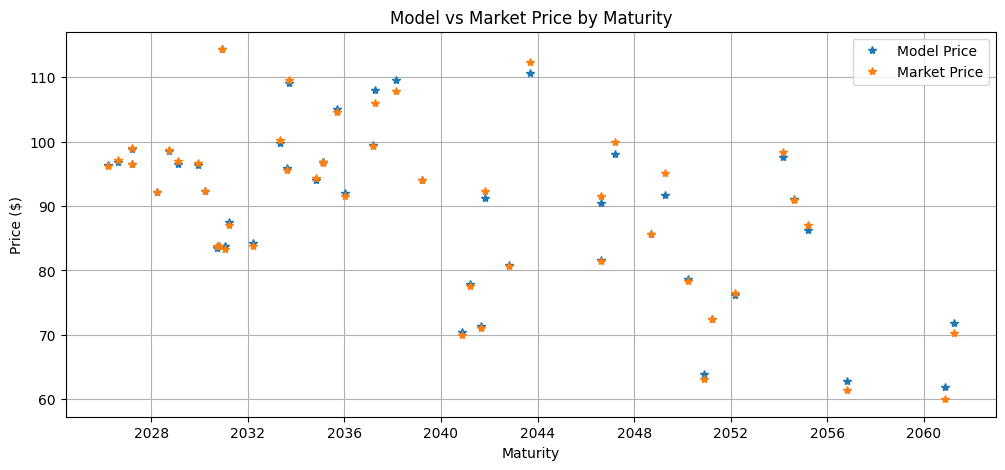

In [192]:
df_metrics = df_vz

plt.figure(figsize=(12, 5))
# X-axis values first, then Y-axis values
plt.plot(df_metrics['maturity'], df_metrics['modelPrice'], '*', label='Model Price') 
plt.plot(df_metrics['maturity'], df_metrics['midPrice'], '*', label='Market Price') 
plt.title(f'Model vs Market Price by Maturity')
plt.xlabel('Maturity')
plt.ylabel('Price ($)')
plt.legend()
plt.grid()
plt.show()

## b. Plot the model vs market yields (Y-axis) by maturity (X-axis).

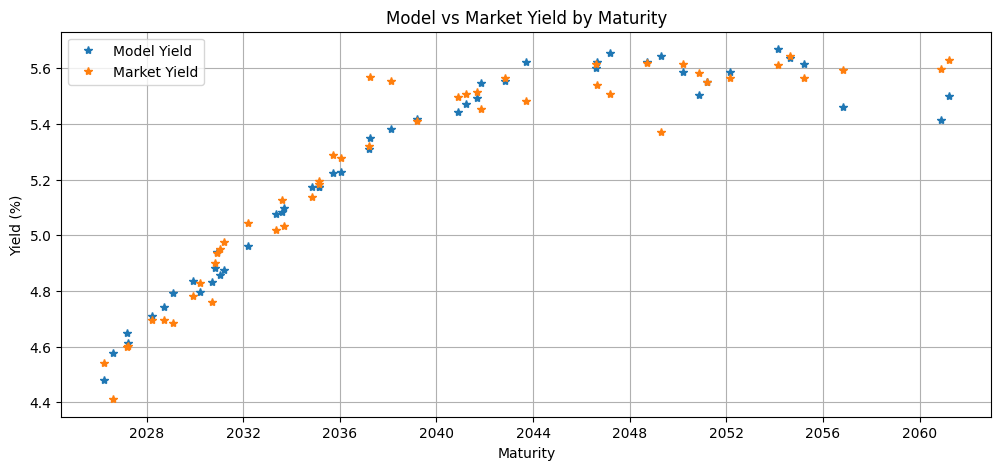

In [193]:
df_metrics = df_vz

plt.figure(figsize=(12, 5))
# X-axis values first, then Y-axis values
plt.plot(df_metrics['maturity'], df_metrics['modelYield'], '*', label='Model Yield') 
plt.plot(df_metrics['maturity'], df_metrics['midYield'], '*', label='Market Yield') 
plt.title(f'Model vs Market Yield by Maturity')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.legend()
plt.grid()
plt.show()

## c. Plot the edges in yield space (Y-axis) by maturity (X-axis).

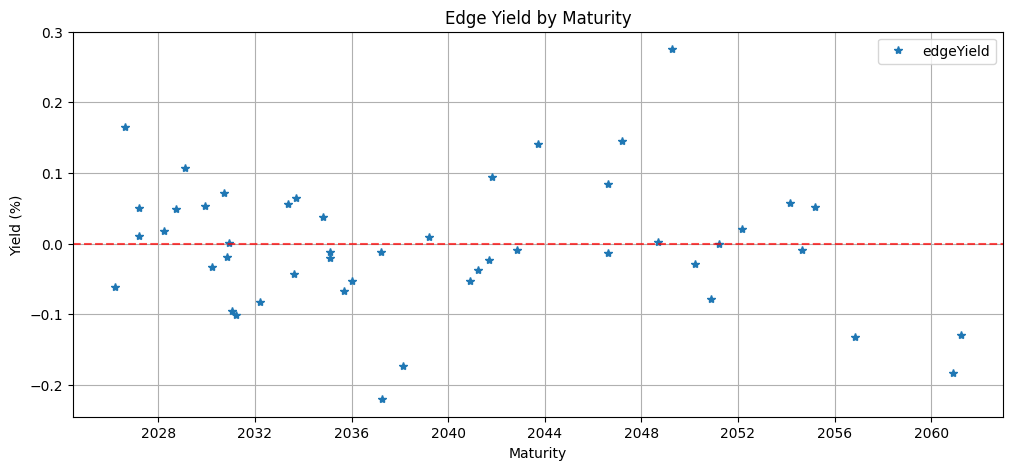

In [194]:
df_metrics = df_vz

plt.figure(figsize=(12, 5))
# X-axis values first, then Y-axis values
plt.plot(df_metrics['maturity'], df_metrics['edgeYield'], '*', label='edgeYield') 
plt.title(f'Edge Yield by Maturity')
plt.xlabel('Maturity')
plt.ylabel('Yield (%)')
plt.axhline(0, color='red', linestyle='--', alpha=0.7)
plt.legend()
plt.grid()
plt.show()

## d. What do you think about the quality of the model fit?

The model fit is very high. We can see that the edge yields are only between -0.2% and 0.3%. The calibrated model yields and prices also fit the market yields and prices; we can see it from the graphs in a) and b). 

The SSE of the final calibrated Nelson-Siegel Model is also very low.

The quality of the model fit is very good. 